In [1]:
import torch
import random
import torchvision.io as tvio
import matplotlib.pyplot as plt
%matplotlib inline

devname = "cuda" if torch.cuda.is_available() else "cpu"
gpu = torch.device(devname)
print(f"Using {gpu} on {torch.cuda.get_device_name(gpu)}")
cpu = "cpu"

sub_size = [8, 8]

Using cuda on NVIDIA GeForce GTX 1050 Ti


In [2]:
def create_training_set():
    sub_img = []
    for n in range(1,40):
        fname = f'images/{n}.png'
        img_data = torch.squeeze(tvio.read_image(fname, tvio.image.ImageReadMode.GRAY)) / 255
        for i in range(img_data.shape[1] - sub_size[1]):
            for j in range(img_data.shape[0] - sub_size[0]):
                sub_img.append(img_data[j:j + sub_size[0], i:i + sub_size[1]])
    return sub_img

tile_set = create_training_set()
random.seed(44)
random.shuffle(tile_set)
img_set = torch.stack(tile_set)
print(img_set.shape)

Xtr = img_set.to(gpu)
print(f'training set: {Xtr.shape}')

#split_idx = int(0.8 * len(img_set))
#Xtr = img_set[:split_idx]
#Xts = img_set[split_idx:]
#print(f'testing set:  {Xts.shape}')


torch.Size([9906624, 8, 8])
training set: torch.Size([9906624, 8, 8])


In [3]:
in_layer = torch.zeros(sub_size[0] * sub_size[1], device = gpu)
h1 = torch.zeros(100, device = gpu)
h2 = torch.zeros(100, device = gpu)
h3 = torch.zeros(40, device = gpu)
h4 = torch.zeros(100, device = gpu)
out_layer = torch.zeros(sub_size[0] * sub_size[1], device = gpu)

g = torch.Generator(device = gpu).manual_seed(12345)

W1 = torch.randn(sub_size[0] * sub_size[1], 100, generator = g, device = gpu)
b1 = torch.randn(100, generator = g, device = gpu)
W2 = torch.randn(100, 100, generator = g, device = gpu)
b2 = torch.randn(100, generator = g, device = gpu)
W3 = torch.randn(100, 40, generator = g, device = gpu)
b3 = torch.randn(40, generator = g, device = gpu)
W4 = torch.randn(40, 100, generator = g, device = gpu)
b4 = torch.randn(100, generator = g, device = gpu)
Wout = torch.randn(100, sub_size[0] * sub_size[1], generator = g, device = gpu)
bout = torch.randn(sub_size[0] * sub_size[1], generator = g, device = gpu)

# W1, b1, W2, b2, W3, b3, W4, b4, Wout, bout = torch.load('params.pt')

params = [W1, b1, W2, b2, W3, b3, W4, b4, Wout, bout]
for p in params:
    p.requires_grad = True

In [4]:

afun = lambda p: torch.sigmoid(p)

def compress_pass(in_layer):
    h1 = afun(in_layer @ W1 + b1)
    h2 = afun(h1 @ W2 + b2)
    h3 = afun(h2 @ W3 + b3)
    h3q = torch.round(h3 * 255)
    return h3, h3q
 
def decompress_pass(compressed_layer, quantized = False):
    if quantized:
        compressed_layer = compressed_layer / 255
    h4 = afun(compressed_layer @ W4 + b4)
    out_layer = afun(h4 @ Wout + bout)
    return out_layer


Loss: 0.005663997493684292; min: 0.0010745166800916195, max: 0.035673320293426514
Loss: 0.005662722047418356; min: 0.0010745166800916195, max: 0.035673320293426514
Loss: 0.005674784537404776; min: 0.0010745166800916195, max: 0.035673320293426514
Loss: 0.005667397752404213; min: 0.0009637101320549846, max: 0.035673320293426514
Loss: 0.005659173242747784; min: 0.0009637101320549846, max: 0.035673320293426514


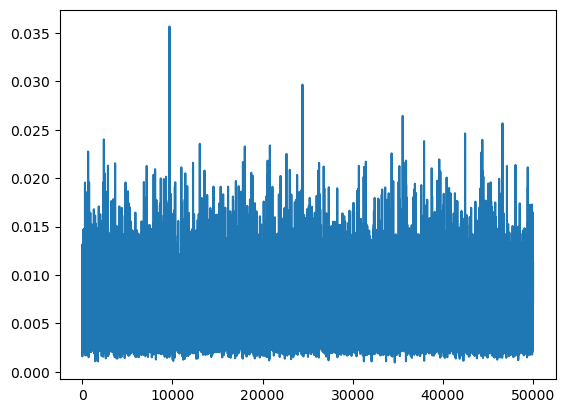

In [25]:
batch_sz = 8
loss_e = []
lr = 0.05
for ep in range(5):
    for e in range(10000):
        for i in range(20):
            idx = random.randrange(len(Xtr) - batch_sz)
            in_layer = Xtr[idx:idx + batch_sz].view(-1, sub_size[0] * sub_size[1])
            h, q = compress_pass(in_layer)
            out_layer = decompress_pass(h)
            loss = torch.sum(torch.sum((in_layer - out_layer)**2, dim = 1) / (sub_size[0] * sub_size[1])) / batch_sz
            for p in params:
                p.grad = None
            loss.backward()
            for p in params:
                p.data += -lr * p.grad
        loss_e.append(loss)
    loss_es = torch.stack(loss_e)
    print(f"Loss: {torch.mean(loss_es)}; min: {torch.min(loss_es)}, max: {torch.max(loss_es)}")

plt.plot(torch.detach(loss_es.to(cpu)))

In [26]:
def compress_img(tst_img):
    comp_data = []
    decomp_data = []
    for i in range(0, tst_img.shape[1], sub_size[1]):
        for j in range(0, tst_img.shape[0], sub_size[0]):
            sub_img = tst_img[j:j+sub_size[0], i:i+sub_size[1]]
            sub_comp, _ = compress_pass(sub_img.to(gpu).flatten())
            comp_data.append(sub_comp)
    return  comp_data

def decompress_img(comp_data, shape):
    tst_decomp = torch.zeros(shape, device = gpu)
    di = 0
    for i in range(0, shape[1], sub_size[1]):
        for j in range(0, shape[0], sub_size[0]):
            sub_decomp = decompress_pass(comp_data[di])
            for k in range (0, sub_size[1]):
                for l in range(0, sub_size[0]):
                    tst_decomp[j + l, i + k] = sub_decomp.view(sub_size[0], sub_size[1])[l, k]
            di = di +1
    return tst_decomp.to(cpu)



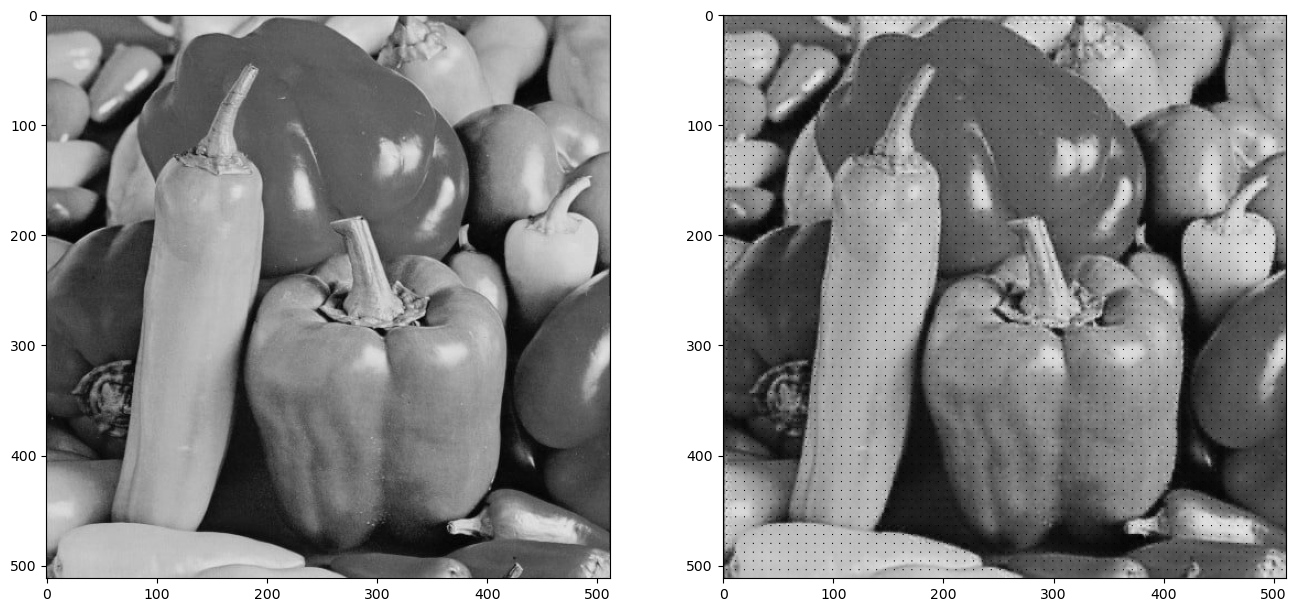

In [27]:
tst_img_1 = torch.squeeze(tvio.read_image('peppers.png', tvio.image.ImageReadMode.GRAY)) / 255
comp_1 = compress_img(tst_img_1)
tst_decomp_1 = decompress_img(comp_1, tst_img_1.shape)
_, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 8))
ax[0].imshow(tst_img_1, cmap='gray', vmin=0, vmax=1.0)
ax[1].imshow(tst_decomp_1.detach(), cmap='gray', vmin=0, vmax=1.0)

torch.Size([512, 512])


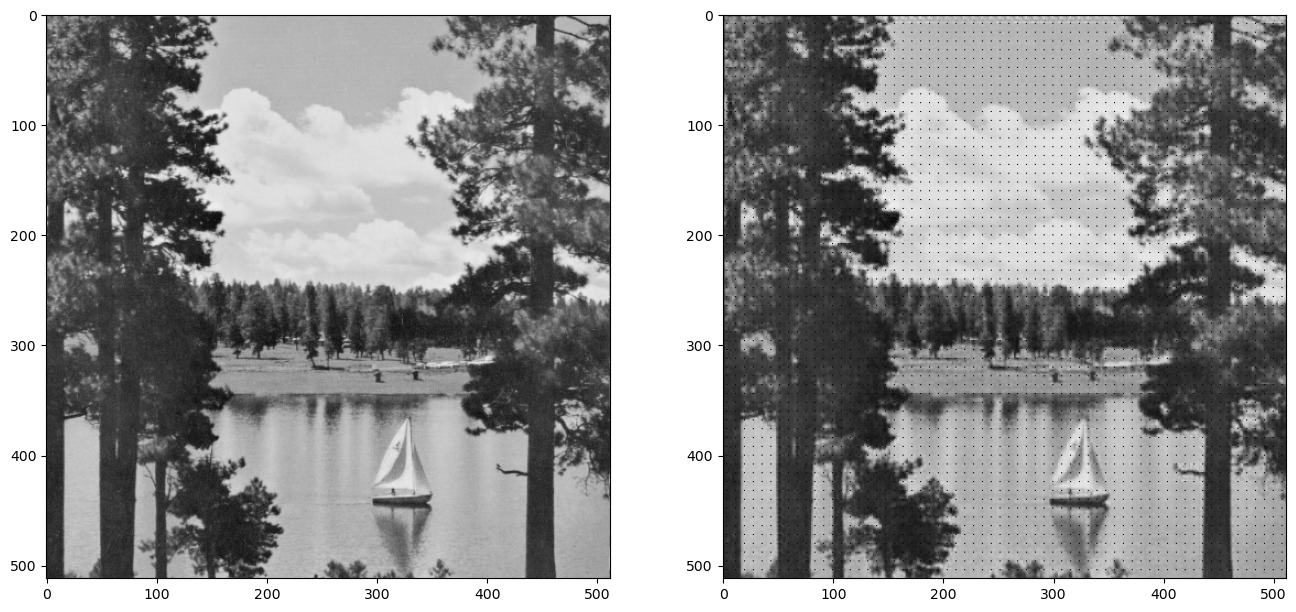

In [21]:
tst_img_2 = torch.squeeze(tvio.read_image('images/45.png', tvio.image.ImageReadMode.GRAY)) / 255
print(tst_img_2.shape)
comp_2 = compress_img(tst_img_2)
tst_decomp_2 = decompress_img(comp_2, tst_img_2.shape)
_, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 8))
ax[0].imshow(tst_img_2, cmap='gray', vmin=0, vmax=1.0)
ax[1].imshow(tst_decomp_2.detach(), cmap='gray', vmin=0, vmax=1.0)

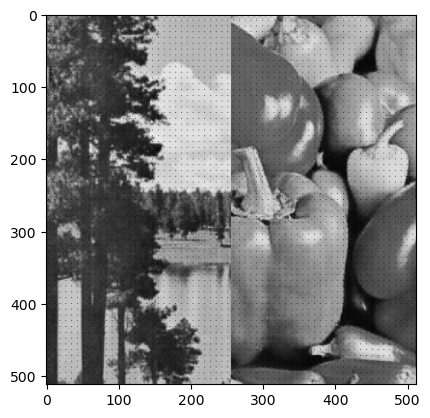

In [22]:
csplit = int(len(comp_1) / 2)
comp_3 = comp_1
comp_3[:csplit] = comp_2[:csplit]

tst_decomp_3 = decompress_img(comp_3, tst_img_2.shape)
plt.imshow(tst_decomp_3.detach(), cmap='gray', vmin=0, vmax=1.0)

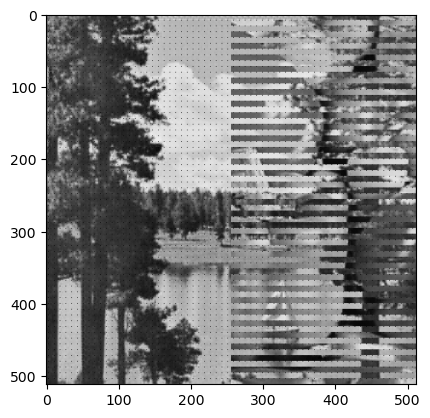

In [23]:
comp_4 = None
tst_decomp_4 = None
comp_4 = comp_1
for i in range(0, len(comp_1), 2):
    comp_4[i] = comp_2[i]
tst_decomp_4 = decompress_img(comp_4, tst_img_1.shape)
plt.imshow(tst_decomp_4.detach(), cmap='gray', vmin=0, vmax=1.0)

In [28]:
torch.save(params, 'params.pt')